In [1]:
import numpy as np
import scipy
import scipy.ndimage as nd
import scipy.cluster.vq as vq
from PIL import Image
import math
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
from matplotlib import pyplot as plt

In [2]:
# read in 3 images as numpy arrays
img1 = Image.open('img01.jpg')
img1 = np.asarray(img1, dtype=np.uint8)

img2 = Image.open('img02.jpg')
img2 = np.asarray(img2, dtype=np.uint8)

img3 = Image.open('img03.jpg')
img3 = np.asarray(img3, dtype=np.uint8)

In [4]:
# Helper function which declares an array that will keep track of the probabilities of an pixel belonging to 
# a particular cluster.
def gen_temp_arrays(arr, num):
    arr1 = np.zeros((len(arr), len(arr[0]), num))
    return arr1

In [5]:
def find_wij(pixel, means, probs, cur_mean, num_means, temp_probs, x, y):
    '''
    Computes the W_ij term (essentially the probabilities for a pixel to belong to a particular blob).
    @param pixel: The current pixel for which we are computing the probabilities (the X_i).
    @param means: The current array of means for the j clusters.
    @param probs: The current array of proportions for the j clusters.
    @param cur_mean: The current mean index we are computing for (The u_j).
    @param num_means: The total number of means, which is equivilant to the total number of clusters.
    '''
    # Cast to float to get faster run-times.
    mean_f = means.astype(float)
    pixel_f = pixel.astype(float)    
        
    # For each of the clusters, we compute the inner value of the exponential.
    val = [-0.5 * np.dot((pixel_f - mean_f[i]), (pixel_f - mean_f[i])) for i in range(num_means)]
    
    # Then shift each of the values by subtracting from the largest element in the list.
    # This corrects for potential underflow or overflow issues.
    val -= max(val)
    
    # Compute the numerator which is the exponential of the gaussian expression with the cur_mean multiplied by 
    # the probability of the current blob being expressed by the dataset.
    numer = np.exp(val[cur_mean])*probs[cur_mean]
    
    # Now take the sum of the exponentials of the gaussian expression with each of the cluster means multiplied by
    # the probability of the "j_th" blob being expressed by the dataset.    
    denom = np.dot(np.exp(val), probs)
    
    # Return the divison of each of these two numbers, which roughly expresses the probability of this pixel belonging to
    # the blob.
    wij = numer / denom
    temp_probs[x][y][cur_mean] = wij
    
    return wij

In [6]:
def shift_and_normalize(image):
    '''
    After talking with the TAs, we came to the conclusion that only 
    shifting the mean to be zero and having unit standard deviation.
    @param image: The image to perform the affine transformation on.
    '''
    
    # First shift the image such that it has zero mean
    mean = np.mean(image, axis=(0,1))
    image = (image - np.mean(image, axis=(0, 1)))
    
    # Now scale by dividing by the standard deviation.
    temp_image = np.reshape(image, (len(image) * len(image[0]), 3))
    
    # Compute the Standard deviation for the RGB values.
    std_dev = np.std(temp_image, axis=0)
    result = image / std_dev
    
    # Return the normalized image with the old std_dev and the means.
    return mean, std_dev, image

In [7]:
def em_step(num_means, image, is_random = False):
    '''
    This function performs the iterative 'E' and 'M' step for the mixture of gaussians.
    @param num_means: The number of segments(clusters) to use.
    @param image: The image where the clustering will take place, represented as an numpy array.
    @param is_random: Determines whether or not to have 
    '''
    # Define a tolerance to which we know when to stop.
    eps = 4
    temp_array = np.reshape(img1, (len(img1) * len(img1[0]), 3))

    # Generate the init_means and init_pi(s)
    kmeans = KMeans(n_clusters=num_means, max_iter=1).fit(temp_array)
    init_mean = kmeans.cluster_centers_
    init_pi = np.array([len(np.where(kmeans.labels_== x)[0]) for x in np.unique(kmeans.labels_)]).astype('float32')/len(kmeans.labels_)
#     init_pi = np.full((num_means,), 1./num_means)
#     init_mean = np.zeros((num_means, 3))
    num_pixels = len(image) * len(image[0])
    # Set the initial mean vector to be randomly sampled pixels from the image.\n",
#     for m in range(num_means):
#         rand_row = np.random.randint(0, len(image))
#         rand_col = np.random.randint(0, len(image[0]))
#         init_mean[m] = image[rand_row][rand_col]
        
    # Construct a vector that will hold the probabilities that a particular pixel belongs to a specific cluster.\n",
    temp_probs = gen_temp_arrays(image, num_means)
        
    # Construct a vector that will hold the probabilities that a particular pixel belongs to a specific cluster.
    temp_probs = gen_temp_arrays(image, num_means)
    #old_mean, old_std_dev, new_image = shift_and_normalize(image)
    new_image = image
    num_pixels = len(image) * len(image[0])
    print(init_mean.shape)
    old_mean = np.copy(init_mean)
    count = 0
    
    # Iterate over each cluster. For each cluster compute the probability that a pixel belongs to a cluster.
    # Use these probabilities to calculate a new approximation for both the mean and proportion of the cluster.
    # We will set a max_iteration of 60, but if it reaches a local min it will converge.
    for outer in range(60):
        for curMeanIndex in range(len(init_mean)):
            numerator = np.zeros((3, ))
            denominator = 0
            for i in range(len(image)):
                for j in range(len(image[0])):
                    # Compute the probability that this pixel is a member of this cluster.
                    temp_pixel = new_image[i][j]
                    wij = find_wij(temp_pixel, init_mean, init_pi, curMeanIndex, num_means, temp_probs, i, j)
                    
                    # Use this probability to compute the updated means and proportions for this dataset.
                    numerator += temp_pixel * wij
                    denominator += wij


            # Update the value of the mean for the particular 'blob'.
            newMean = (numerator / denominator)
            newPop = (denominator / num_pixels)
                        
            
            # Otherwise update the estimate of the mean and proportion of the particular cluster.
            init_mean[curMeanIndex] = newMean
            init_pi[curMeanIndex] = newPop
        
        
        diff = sum([euclidean(init_mean[a], old_mean[a]) for a in range(len(init_mean))])
        print("Done with iteration " + str(outer))
        print(diff)
        if (diff < eps):
            return init_mean, init_pi, temp_probs
        count += 1
        
        old_mean = np.copy(init_mean)
            
        
        
        
    return (init_mean, init_pi, temp_probs)        


First, we will segment the first image into 10, 20, and 50 segments.

In [8]:
img1_mean_10, img1_pi_10, img1_temp_probs_10 = em_step(10, img1)
img2_mean_10, img2_pi_10, img2_temp_probs_10 = em_step(10, img2)
img3_mean_10, img3_pi_10, img3_temp_probs_10 = em_step(10, img3)

(10, 3)
Done with iteration 0
48.7246087077573
Done with iteration 1
19.006606740552044
Done with iteration 2
9.039299039591441
Done with iteration 3
5.274368882275565
Done with iteration 4
3.5202585168061575
(10, 3)
Done with iteration 0
472.43493683352483
Done with iteration 1
155.4280262072892
Done with iteration 2
79.54942654637041
Done with iteration 3
50.09435365876974
Done with iteration 4
32.73898511933826
Done with iteration 5
21.31821421636966
Done with iteration 6
16.99805675737745
Done with iteration 7
15.41102099217226
Done with iteration 8
15.948269786524028
Done with iteration 9
17.795745318892926
Done with iteration 10
16.817593718341204
Done with iteration 11
15.425866013016098
Done with iteration 12
15.118794148384534
Done with iteration 13
15.465565844978858
Done with iteration 14
15.705350098960766
Done with iteration 15
16.17405690566854
Done with iteration 16
14.21335242519676
Done with iteration 17
11.838214124209596
Done with iteration 18
9.931744346147916
Done 

In [20]:
img1_mean = img1_mean_10.astype(np.uint8)
img2_mean = img2_mean_10.astype(np.uint8)
img3_mean = img3_mean_10.astype(np.uint8)
img1_mean2 = img1_mean_20.astype(np.uint8)


In [21]:
new_img = np.zeros((len(img1), len(img1[0]), 3))
for i in range(len(img1)):
    for j in range(len(img1[0])):
        val_max = np.argmax(img1_temp_probs_10[i][j])
        new_img[i][j] = img1_mean_10[val_max]

new_img2 = np.zeros((len(img2), len(img2[0]), 3))
for i in range(len(img2)):
    for j in range(len(img2[0])):
        val_max = np.argmax(img2_temp_probs_10[i][j])
        new_img2[i][j] = img2_mean_10[val_max]

new_img3 = np.zeros((len(img3), len(img3[0]), 3))
for i in range(len(img3)):
    for j in range(len(img3[0])):
        val_max = np.argmax(img3_temp_probs_10[i][j])
        new_img3[i][j] = img3_mean_10[val_max]


new_img4 = np.zeros((len(img1), len(img1[0]), 3))
for i in range(len(img1)):
    for j in range(len(img1[0])):
        val_max = np.argmax(img1_temp_probs_20[i][j])
        new_img4[i][j] = img1_mean_20[val_max]

In [22]:
new_img = new_img.astype(np.uint8)
new_img2 = new_img2.astype(np.uint8)
new_img3 = new_img3.astype(np.uint8)
new_img4 = new_img4.astype(np.uint8)

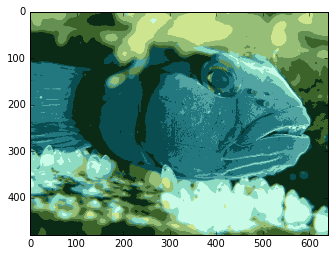

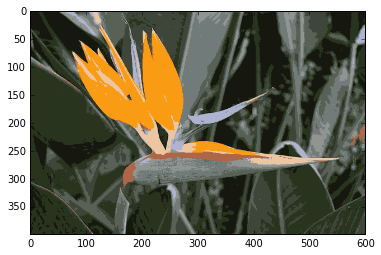

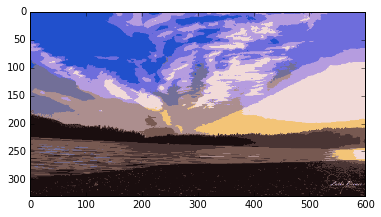

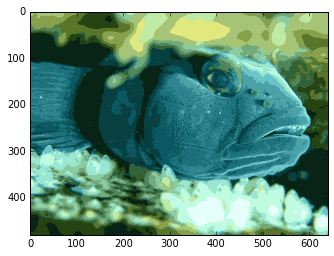

In [23]:
plt.imshow(new_img)
plt.show()
plt.imshow(new_img2)
plt.show()
plt.imshow(new_img3)
plt.show()
plt.imshow(new_img4)
plt.show()

In [16]:
print(img1_mean)

[[100 144  84]
 [200 251 231]
 [ 10  77  80]
 [151 190 118]
 [ 11  43  23]
 [ 35 120 128]
 [ 60  99  42]
 [204 229 142]
 [142 219 196]
 [ 81 164 162]]


In [17]:
img1_mean_20, img1_pi_20, img1_temp_probs_20 = em_step(20, img1)
img2_mean_20, img2_pi_20, img2_temp_probs_20 = em_step(20, img2)
list_of_sunset_means = list()
for i in range(5):
    list_of_sunset_means.append(em_step(20, img3))

(20, 3)
Done with iteration 0
49.639345676507105
Done with iteration 1
25.615120255368563
Done with iteration 2
16.30868134939826
Done with iteration 3
12.609990259617698
Done with iteration 4
11.170210428665996
Done with iteration 5
10.236729509383292
Done with iteration 6
9.903165268025232
Done with iteration 7
9.570846355622482
Done with iteration 8
9.966269906553087
Done with iteration 9
9.071206049610792
Done with iteration 10
7.7819215885432325
Done with iteration 11
7.7326433836940875
Done with iteration 12
7.605785286241016
Done with iteration 13
6.645089657682626
Done with iteration 14
6.0071925944650815
Done with iteration 15
5.567503777284394
Done with iteration 16
5.493549242520508
Done with iteration 17
5.122357774967085
Done with iteration 18
4.626285025445909
Done with iteration 19
4.072338692365583
Done with iteration 20
4.1595024205444755
Done with iteration 21
4.287791852361108
Done with iteration 22
3.9053474403825406
(20, 3)
Done with iteration 0
823.0403862948417
D

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:55: RuntimeWarning: invalid value encountered in true_divide


ValueError: array must not contain infs or NaNs

In [19]:
img1_mean_50, img1_pi_50, img1_temp_probs_50 = em_step(50, img1)


(50, 3)
Done with iteration 0
75.94296864380746


KeyboardInterrupt: 

In [ ]:
img2_mean_50, img2_pi_50, img2_temp_probs_50 = em_step(50, img2)


In [ ]:
img3_mean_50, img3_pi_50, img3_temp_probs_50 = em_step(50, img3)